In [1]:
%matplotlib inline

import gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import utils.rl_utils as rl_utils

from alg.ppo import PPO

In [2]:
env_name = "CartPole-v0"
env = gym.make("CartPole-v0")

/home/luohx/Software/anaconda/envs/python_38-pytorch_1.7.0/lib/python3.8/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


**Observation space**: The observation is a 4-dimensional vector $\mathcal{S} \in \mathbb{R}^4$, where each element represents:
- Cart position: $x \in [-4.8, 4.8]$
- Cart velocity: $\dot{x} \in (-\infty, \infty)$
- Pole angle: $\theta \in [-24^\circ, 24^\circ]$
- Pole angular velocity: $\dot{\theta} \in (-\infty, \infty)$

**Action space**: $a \in \{0, 1\}$, indicating the direction to apply force on the cart. 
- $0$: Apply force to the left.
- $1$: Apply force to the right.

**Initial state**: The episode starts with the cart at the center of the track ($x = 0$), and the pole almost upright with small random values for the pole angle and velocity.

**Termination of an episode**:
- Case 1: The pole's angle $\theta$ exceeds $24^\circ$ from vertical.
- Case 2: The cart's position $x$ exceeds $4.8$ units from the center.
- Case 3: (Truncation) The episode reaches its maximum length of 200 timesteps.

**Reward**: A reward of $+1$ is provided for every timestep the pole remains balanced, until one of the termination conditions is met.

<img src="./images/cart_pole.gif" alt="cart_pole_env" width="300"/>

In [3]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 500
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
epochs = 10
eps = 0.2

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda, epochs, eps, gamma, device)

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]/home/luohx/Project/rl-start/alg/ppo.py:61: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
Iteration 9: 100%|██████████| 50/50 [00:02<00:00, 18.20it/s, episode=500, return=189.500]


In [4]:
episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

/tmp/ipykernel_558670/1316342276.py:7: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [5]:
from IPython import display
import PIL.Image


def test_trained_policy(agent, env, num_episodes=5):
    for i in range(num_episodes):
        state, _ = env.reset()
        if isinstance(state, tuple):
            state = state[0]
        done = False
        episode_return = 0

        while not done:
            rgb_array = env.render()
            img = PIL.Image.fromarray(rgb_array)
            display.clear_output(wait=True)
            display.display(img)

            action = agent.take_action(state, eval=True)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            if isinstance(next_state, tuple):
                next_state = next_state[0]
            state = next_state
            episode_return += reward

        print(f"Episode {i + 1}, Return: {episode_return}")

    env.close()

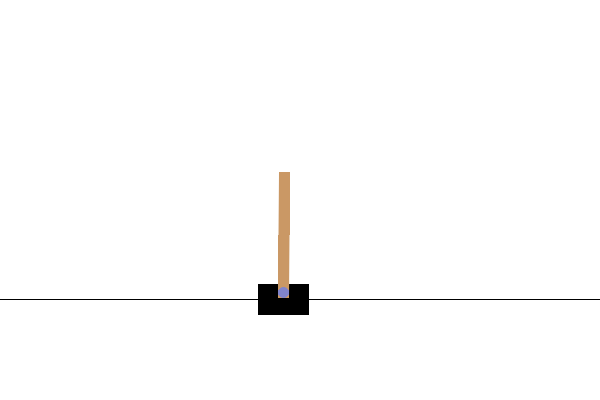

Episode 5, Return: 200.0


In [6]:
env = gym.make("CartPole-v0", render_mode="rgb_array")
test_trained_policy(agent, env)